<a href="https://colab.research.google.com/github/Pythonista7/Implementing_/blob/master/The_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Neural Algorithm of Artistic Style(Implementation in Python-Tensorflow)

### Reference's 
Paper : <br>
<i>A Neural Algorithm of Artistic Style</i>-
Leon A. Gatys, 1,2,3 Alexander S. Ecker, 1,2,4,5 Matthias Bethge 1,2,4<br>
Program/Library Support :<br>
www.tensorflow.org

## Importing Dependencies

In [0]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe 

In [0]:
from tensorflow.python.keras import models
from tensorflow.keras.applications import vgg16,vgg19
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.python.keras.preprocessing import image as keras_preproc_image

In [0]:

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

### Start Executing Eagerly 

In [0]:
tf.enable_eager_execution()

## Network Architecture - VGG

Here we will be using the VGG16 network.Lets take a look at the model architecture to understand it. 

In [0]:
model_demo=vgg16.VGG16()
model_demo.summary()

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 41s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__

## The Layers we will be using to extract features  

In [0]:
content_layers=['block5_conv2']#['block1_conv1','block1_conv2','block2_conv1']
style_layers=['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
no_of_content_layers=len(content_layers)
no_of_style_layers=len(style_layers)
IMG_SIZE=(1000,1000)
loss_log=[]

### Lets Try and Visualize these filters before we train our model 

In [0]:
x=model_demo.get_layer(name=content_layers[0])
x=x.get_weights()

(3, 3, 512)


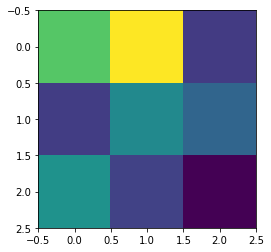

In [0]:
x=x[0][:,:,:,0].squeeze()
print(x.shape)
plt.imshow(x[:,:,0])

We can't really make out anything from this one filter but note the way we do this,may prove to be helpful in the future


### Testing out with 2 different models

In [0]:
#Build a model VGG 16
def build_model_VGG16():
    vgg=vgg16.VGG16(include_top=False)
    vgg.trainable=False
    vgg_style_output=[vgg.get_layer(name).output for name in style_layers]
    vgg_content_output=[vgg.get_layer(name).output for name in content_layers]
    vgg_output=vgg_style_output+vgg_content_output
    return models.Model(vgg.input,vgg_output)

In [0]:
#Build a model VGG 19
def build_model_VGG19():
    vgg=vgg19.VGG19(include_top=False)
    vgg.trainable=False
    vgg_style_output=[vgg.get_layer(name).output for name in style_layers]
    vgg_content_output=[vgg.get_layer(name).output for name in content_layers]
    vgg_output=vgg_style_output+vgg_content_output
    return models.Model(vgg.input,vgg_output)

## Helper Function to Read and De-Process image for Visualization

In [0]:
#load and resize image to fit specifications of the selected model. 
def load_img(img_path):
    img=Image.open(img_path)
    
    img=img.resize(IMG_SIZE)
    img=np.asarray(img)
    
    img=keras_preproc_image.img_to_array(img)
    
    # We need to broadcast the image array such that it has a batch dimension 
    img = np.expand_dims(img, axis=0)
    
    return img

In [0]:
#Function to convert image to type array,useful for displaying
def deproc_img(img): 
  
    #Function might need improvements
  
    img = np.clip(img, 0, 255).astype('int32')
    #Remove batch dim for avoididng error while displaying
    if len(img.shape) == 4:
        img = np.squeeze(img, 0)
        #print("Deproc shape = ",img.shape)
    return img

## Generating Content and Style Loss

The content loss is measured with the help of the mean squared error loss.But using the same technique for calculating style loss would not provide good results ,hence we calculate the gram matrix of the features from style image pass and reproduction image pass and then calculate the mean squred error between them.The gram matrix representation actually helps spread and naturally mix match the style.

### Content Loss

In [0]:
def get_content_loss(input_img,content_img):
    """
    desc:
        function will calculate and return mean-squared error bw the 2 imgs.
        Note: on eager_execution mode ops will be performed and grads will be updated on tf.reduce_mean()
    params:
        input_img is the target image(dtype: tensor)
        content_ img is the img from which the content features are inherited from    (dtype: tensor)
    """
    #print(input_img.shape,"  ",content_img.shape)
    return tf.reduce_mean(tf.squared_difference(input_img,content_img))
    

### Style Loss

In this diagram each color represents a 2-dimensional feature map and the gram matrix is a stacked up matrix of 1 dimensional flattened feature maps from the CNN-layers we had picked earlier(style_layer,content_layer).
![alt text](https://cdn-images-1.medium.com/max/1600/1*HeCcGpmxWZFibgLiZCutag.png)

In [0]:
def get_gram_matrix(input_tensor):
    
    """
    Desc: 
         This function calculates and return the gram matrix from a given input tensor
    """
    
    #First we find the no of channels 
    channels=input_tensor.shape[-1] #The last attribute of shape is the no of channels
    
    #Now we will reshape the content of this image into a flattend vector
    m=tf.reshape(input_tensor,[-1,channels])
    
    #Now we find the product of this m matrix with the transpose(m) to account for all possible correlations
    gram=tf.matmul(tf.transpose(m),m)
    
    #return the gram matrix
    return gram/tf.cast(m.shape[0],dtype=tf.float32)

In [0]:
def get_style_loss(input_img,style_img):#these are tensors not imgs
    
    """
    Note :
        input_img and style_img are feature tensors,{ ref fn compute_loss() where this is called }
        
    Desc : we use GRAM MATRIX as the style representation ,insted of the raw output from the intermediate layers.
            Gram matrix is computed using the intermediate layer representations. 
    """
    
    #Getting gram matrix of style
    gram_style=style_img
    
    #Getting gram matrix of the expected-output-img
    gram_output=get_gram_matrix(input_img)
    
    #calculate and reduce mean of loss bw the above 2
    return tf.reduce_mean(tf.squared_difference(gram_style,gram_output))

## Extracting the Features from the model

In [0]:
def get_feature_from_model(path_style,path_content,model):
    """
    Desc:
        Function takes :
                > path of style img
                > path of content img
                > model
        Function returns :
                > output of the intermediate layers
    """
    #Load the images<<Needs to be changed according to the model used : VGG16/19>>
    
    style_img=vgg16_preprocess_input(load_img(path_style))
    content_img=vgg16_preprocess_input(load_img(path_content))
    
    #Get model outputs for each ,the outputs are tensors
    style_op=model(style_img)
    content_op=model(content_img)
    
    #get the features from the model output
    style_features=[style_layer[0] for style_layer in style_op]
    content_features=[content_layer[0] for content_layer in content_op]
    
    return style_features,content_features

## Visualizing the feature maps from the content & style layers

Here we will try to visualize the feature responses from the choosen style and content layer and see what these filters are picking up.You will notice that some capture one aspect of the image such as grainy texture or detail patters while others pick up the structures within the image.

In [0]:
from google.colab import files
files.upload()

Saving blue_swirls.jpg to blue_swirls.jpg


{'blue_swirls.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xe2\x0cXICC_PROFILE\x00\x01\x01\x00\x00\x0cHLino\x02\x10\x00\x00mntrRGB XYZ \x07\xce\x00\x02\x00\t\x00\x06\x001\x00\x00acspMSFT\x00\x00\x00\x00IEC sRGB\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-HP  \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x11cprt\x00\x00\x01P\x00\x00\x003desc\x00\x00\x01\x84\x00\x00\x00lwtpt\x00\x00\x01\xf0\x00\x00\x00\x14bkpt\x00\x00\x02\x04\x00\x00\x00\x14rXYZ\x00\x00\x02\x18\x00\x00\x00\x14gXYZ\x00\x00\x02,\x00\x00\x00\x14bXYZ\x00\x00\x02@\x00\x00\x00\x14dmnd\x00\x00\x02T\x00\x00\x00pdmdd\x00\x00\x02\xc4\x00\x00\x00\x88vued\x00\x00\x03L\x00\x00\x00\x86view\x00\x00\x03\xd4\x00\x00\x00$lumi\x00\x00\x03\xf8\x00\x00\x00\x14meas\x00\x00\x04\x0c\x00\x00\x00$tech\x00\x00\x040\x00\x00\x00\x0c

In [0]:
ls

blue_swirls.jpg  castle.jpg  sample_data/


In [0]:
#Specify paths of content and style image 
content_img_path='castle.jpg'
style_img_path='blue_swirls.jpg'

In [0]:
model_demo=build_model_VGG16()


In [0]:
s_f,c_f=get_feature_from_model(style_img_path,content_img_path,model_demo)

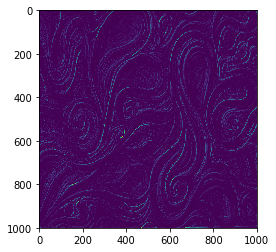

In [0]:
s_f[0][:,:,0].shape
t=s_f[0][:,:,0]
plt.imshow(t)

In [0]:
s_f[1][:,:,0].shape


TensorShape([Dimension(500), Dimension(500)])

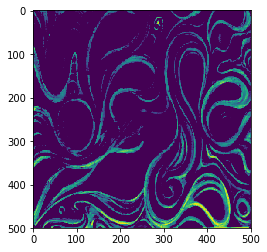

In [0]:
t=s_f[1][:,:,0]
plt.imshow(t)

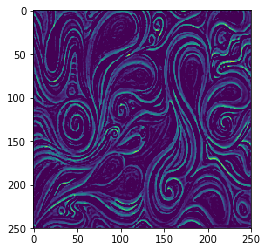

In [0]:
t=s_f[2][:,:,0]
plt.imshow(t)

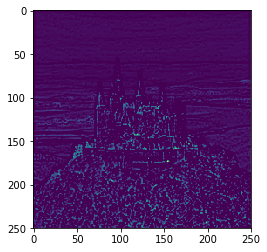

In [0]:
t=c_f[2][:,:,0]
plt.imshow(t)

## Now to compute loss

In [0]:
def compute_loss(model,loss_weights,init_img,content_features,style_features):
    """
    Params:
    
    model= init model defined in run_ST()
    init_img= base image to add content and style
    content_features=list of tensors from model after content img pass
    style_features=gram matrix of list of tensors from model after style img pass
    
    Returns:
    
    The total loss, style loss, content loss
    
    """   
    
    model_op=model(init_img)
    
    style_output_features = model_op[:no_of_style_layers] #Retives all style layers from model output after init_img pass
    
    content_output_features = model_op[no_of_style_layers:] #Retrives all content op from model op after init_img pass
    
    style_loss=0
    content_loss=0
    
    # Now we need to cal and update style_loss
    #NOTE:Init img is the one we are modifying and will be our resultant img
    #Below style_features is the gram_matrix features from style img and style_op_f is from init_img pass from model
    for target_style_feature,init_feature in zip(style_features,style_output_features):
        #We can normalize this value to save some compute
        style_loss+=get_style_loss(init_feature[0],target_style_feature)/no_of_style_layers
    
    
    for content_output_feature,init_feature in zip(content_features,content_output_features):
        #We can normalize this value to save some compute
        content_loss+=get_content_loss(init_feature[0],content_output_feature)/no_of_content_layers    

        
        #Now we need to weight the computed losses to the wt_scale_factors(style_weights) passed from run_ST()
    #refer loss_param_dict key 'loss_weights'
    style_wt,content_wt=loss_weights
    
    style_loss*=style_wt
    content_loss*=content_wt
    
    #Sum to get total loss
    tot_loss=style_loss+content_loss
    #print(tot_loss)
    return tot_loss,style_loss,content_loss  

In [0]:
def compute_grads(loss_param_dict):
    
    with tf.GradientTape() as tape:
        loss=compute_loss(**loss_param_dict)# ** is used to unpack dict to the corresponding named fn params
    tot_loss=loss[0]
    #print(loss[0])
    #now we can compute grads wrt to init_img
    grads=tape.gradient(tot_loss,loss_param_dict['init_img'])
    
    return loss,grads
        

In [0]:
def run_ST(content_img_path,
           style_img_path,
           no_of_iter=100,
           style_wt=0.1,
           content_wt=1):

    #Load the pre-trained model
    model= build_model_VGG19()
    
    #Min and max values for image pixels
    min_val=0
    max_val=255
    
    #Make model.trainable = False 
    
    #get content and style features by calling the respective functions 
    style_featues,content_features = get_feature_from_model(style_img_path,content_img_path,model)
    #print("Style features\n",style_featues,"\nContent Features in run ST\n",content_features)

    #Generate Gram matrices for all style features
    gram_features=[get_gram_matrix(s_feature) for s_feature in style_featues]
    
    #Load init image
    init_img=load_img(content_img_path)
    
    #Set up image as tensor
    init_img=tfe.Variable(init_img,tf.uint8)
    
    #Define optimizer
    opt=tf.train.AdamOptimizer(learning_rate=5)
    
    #log var for logging best loss and best image generated by the model
    best_loss=float('inf')
    best_img=None
    
    #packing both losses into tuple to pass to get_loss() 
    loss_wt=(style_wt,content_wt)
    
    #log images-loss
    global loss_log
    
    #Create a dict to feed loss_calc() function
    loss_param_dict={
                    'model':model,
                    'loss_weights':loss_wt,
                    'init_img':init_img,
                    'content_features':content_features[no_of_style_layers:],
                    'style_features':gram_features
                    }
    
    for i in range(no_of_iter+1):
        
        #Compute the gradients for backprop
        loss,grads=compute_grads(loss_param_dict)
        
        #Unpacking all losses
        tot_loss,style_loss,content_loss=loss
        
        #Apply gradients to variables.
        """
        Args:
         > grads_and_vars: List of (gradient, variable) pairs as returned by compute_gradients().
        """
        opt.apply_gradients([(grads,init_img)])
        
        #we need to restrict pixel data to display it as img
        img_tensor=tf.clip_by_value(init_img,min_val,max_val)
        
        #Append Loss
        loss_log.append(tot_loss)
        
        #Assign the clipped tensor as init
        init_img.assign(img_tensor)
        
        #We shall track the best minimum loss achieved here
        if tot_loss<best_loss:
            best_loss=tot_loss
            best_img=deproc_img(init_img.numpy())
        
        #We print out the loss every 10 iterations 
        if i%10==0:

            print("Best loss at ",i," was ==> ",best_loss.numpy())
            f_nm='best_img'+str(i)+'.png'
            plt.imsave(f_nm,best_img)
            

    return best_img,best_loss 

## Putting Everything to Work

In [0]:
from google.colab import files
files.upload()

{}

In [0]:
#Specify paths of content and style image 
style_img_path="blue_swirls.jpg"
content_img_path='castle.jpg'

## Content Image

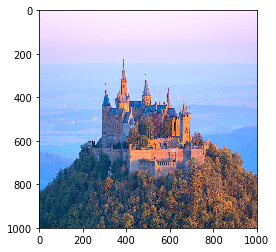

In [0]:
img=load_img(content_img_path)
plt.imshow(deproc_img(img))

## Style Image

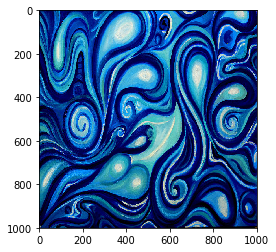

In [0]:
img=load_img(style_img_path)
plt.imshow(deproc_img(img))

In [0]:
#Running the below cell will start the style transfer process

In [0]:
best_img,best_loss=run_ST(content_img_path,style_img_path,no_of_iter=100)

80142336/80134624 [==============================] - 7s 0us/step
Best loss at  0  was ==>  10225560000.0
Best loss at  10  was ==>  2684167000.0
Best loss at  20  was ==>  1508938800.0
Best loss at  30  was ==>  1015081600.0
Best loss at  40  was ==>  745176450.0
Best loss at  50  was ==>  582223300.0
Best loss at  60  was ==>  477324100.0
Best loss at  70  was ==>  405350500.0
Best loss at  80  was ==>  353073630.0
Best loss at  90  was ==>  313528800.0
Best loss at  100  was ==>  282630620.0


In [0]:
print("Min Loss Achieved =",best_loss.numpy())

Min Loss Achieved = 282630620.0


### Download the image

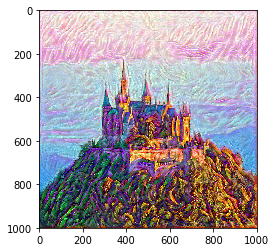

In [0]:
img=plt.imread("best_img100.png")
plt.imshow(img)
#files.download('best_img100.png')


The above is the reproduced content image in the style of the style-image.





### Log and Plot the loss

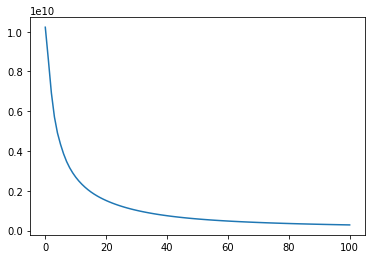

In [0]:
loss=[x.numpy() for x in loss_log]
plt.plot(loss)

In [0]:
#Clear loss var for next-time
global loss_log
loss_log=[]

In [0]:
#Below 2 lines can be used to download all the images saved at every 10 img intervals.
#NOTE : Change the for loop limit to the epoch count accordingly
file_nms=["best_img_person"+str(x)+".png" for x in range(0,101,10)]
i=[files.download(x) for x in file_nms]

# END